In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in E.coli - BacDrop

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/pseudomonas_data_processed.h5ad")


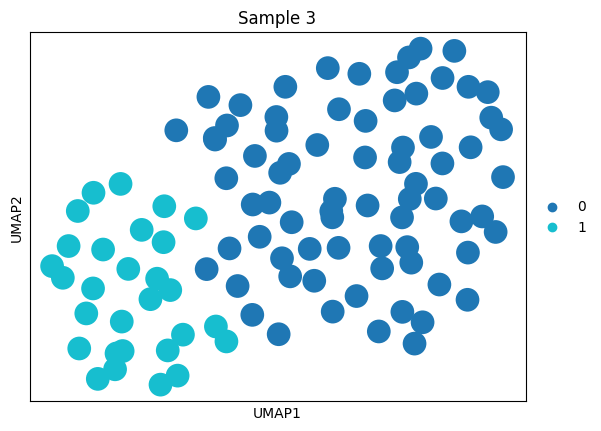

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 500
Both NB and ZINB not converged! Using NB without starting params
gene 600


In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-NP_064721.1,4,0.038835,0.038100,96.116505,4.0,1.609438,4,0.037327,False,1.857413,...,NP_064721.1,chromosome replication initiator DnaA,dnaA,0.038835,0.037327,0.001508,poi,0.038835,inf,0.000148
cds-NP_064722.1,5,0.048544,0.047402,95.145631,5.0,1.791759,5,0.046187,False,2.081567,...,NP_064722.1,DNA polymerase III subunit beta,dnaN,0.048544,0.046187,0.002356,poi,0.048540,inf,0.000103
cds-NP_064723.1,9,0.097087,0.092659,91.262136,10.0,2.397895,9,0.107079,False,1.723838,...,NP_064723.1,DNA replication and repair protein RecF,recF,0.097087,0.107079,-0.009992,nb,0.097090,0.818744,0.000000
cds-NP_064724.1,7,0.077670,0.074801,93.203883,8.0,2.197225,7,0.091055,False,0.936137,...,NP_064724.1,DNA gyrase subunit B,gyrB,0.077670,0.091055,-0.013385,nb,0.077669,0.376754,0.000000
cds-NP_064728.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490749,...,NP_064728.1,glycine--tRNA ligase subunit beta,glyS,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_254251.1,2,0.019417,0.019231,98.058252,2.0,1.098612,2,0.019040,False,1.325264,...,NP_254251.1,16S rRNA methyltransferase GidB,gidB,0.019417,0.019040,0.000377,poi,0.019420,inf,0.000611
cds-NP_254252.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490749,...,NP_254252.1,tRNA uridine 5-carboxymethylaminomethyl modifi...,gidA,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
cds-NP_254255.1,6,0.058252,0.056619,94.174757,6.0,1.945910,6,0.054859,False,2.264614,...,NP_254255.1,inner membrane protein translocase subunit YidC,NaN,0.058252,0.054859,0.003393,poi,0.058253,inf,0.000108
cds-NP_254256.1,4,0.048544,0.047402,96.116505,5.0,1.791759,4,0.065605,False,0.271007,...,NP_254256.1,ribonuclease P,rnpA,0.048544,0.065605,-0.017061,nb,0.048540,0.102454,0.000000


## Find optimal correlation matrix scaling and generate synthetic null data

In [16]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 0.5665250945183552
Factor: 2 - Error: 0.5665250945183552
Factor: 3.6180339999999998 - Error: 0.5665250945183552
1


In [17]:
importlib.reload(cd)
xmin=1

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [18]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [23]:
data_null_gen.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [25]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

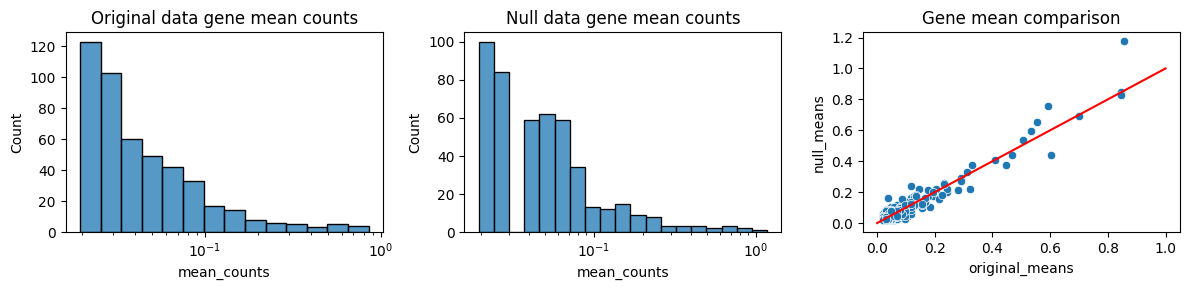

SignificanceResult(statistic=0.7539288800776617, pvalue=8.505517892388706e-88)


In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

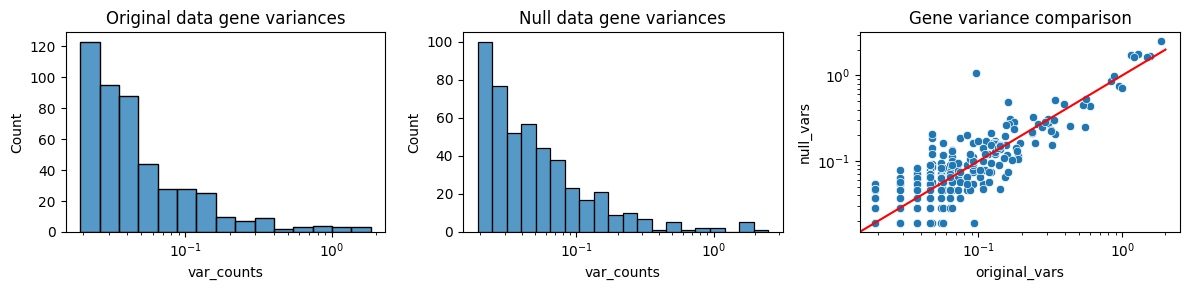

SignificanceResult(statistic=0.7737363088218153, pvalue=3.161364897834406e-95)
[[1.         0.94350934]
 [0.94350934 1.        ]]


In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

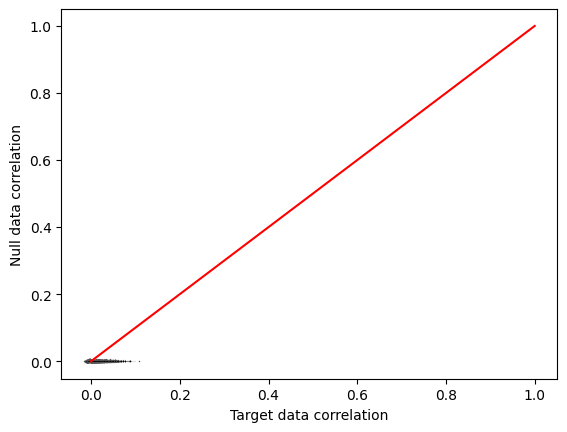

In [28]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [30]:
#sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [31]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


50


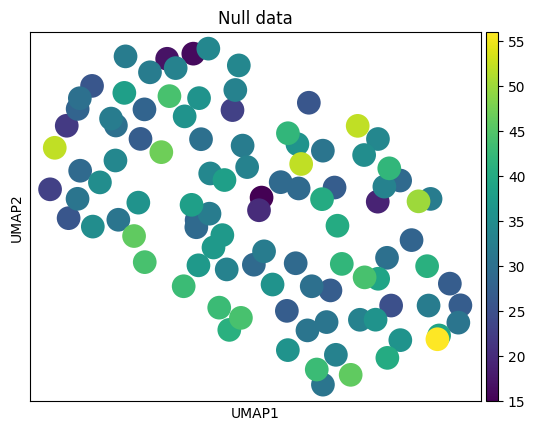

In [32]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [33]:
data_null_gen.write(data_path + "/null_data_pseudomonas.h5ad")

In [34]:
n_splits = 20
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    
    while twoclust is False:
        if nclust < 2:
            if was_greater:
                res2 += 0.01
            else:
                res2 += 0.05
        else:
            res2 -= 0.01
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

resolution: 0.06, clusters: 1
resolution: 0.11, clusters: 1
resolution: 0.16, clusters: 1
resolution: 0.21, clusters: 1
resolution: 0.26, clusters: 1
resolution: 0.31, clusters: 2
split 1/20 - Resolution 0.31
resolution: 0.31, clusters: 2
split 2/20 - Resolution 0.31
resolution: 0.31, clusters: 2
split 3/20 - Resolution 0.31
resolution: 0.31, clusters: 1
resolution: 0.36, clusters: 2
split 4/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 5/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 6/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 7/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 8/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 9/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 10/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 11/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 12/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 13/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 14/20 - Resol

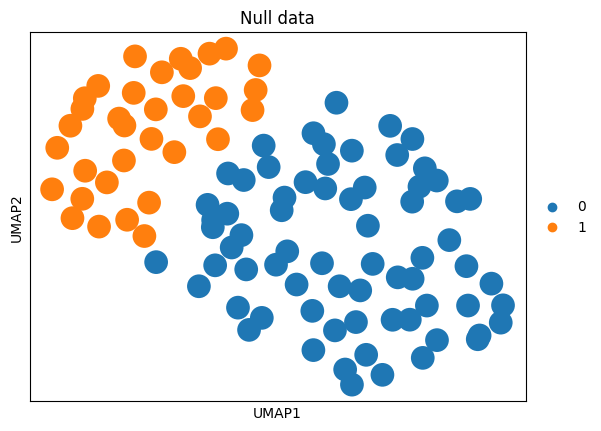

In [35]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [36]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals_dict[best_split]}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 1 - DE genes: 61; Minimum q value: 0.02040816326530612
Cluster 0 - DE genes: 61; Minimum q value: 0.02040816326530612


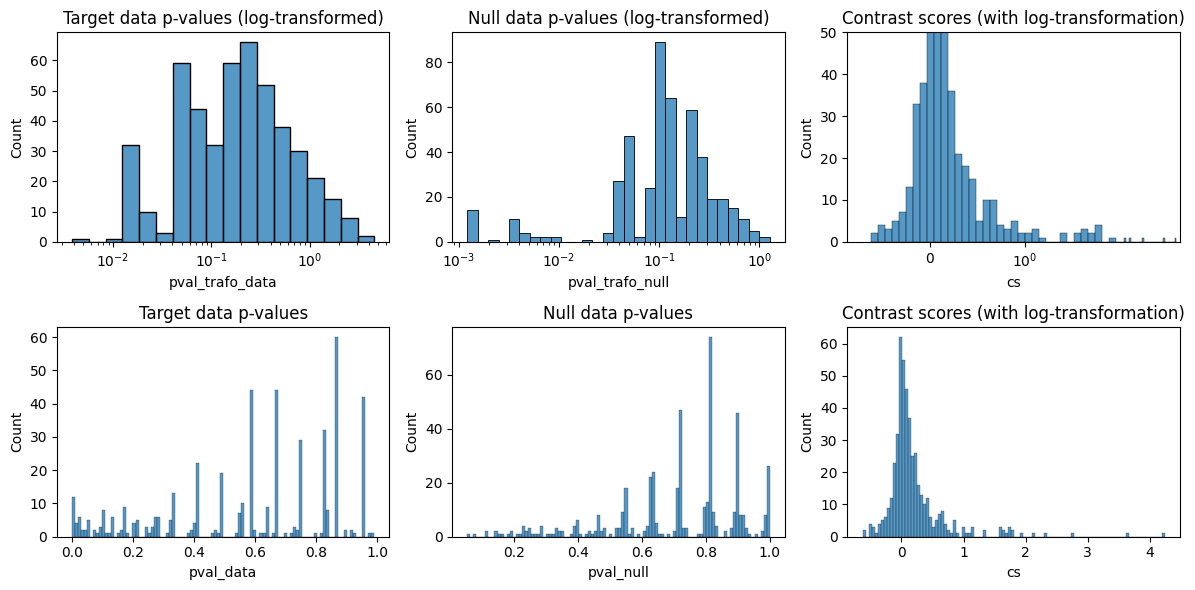

In [38]:
c = "0"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [39]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 1
0.020408     49
0.049180     12
0.095238      2
0.106061      3
0.115942      3
0.120879     22
0.139785      2
0.145833      3
0.148515      5
0.170940     16
0.184874      2
0.191667      1
0.192857     20
0.212766      1
0.215278      3
0.219178      2
0.224490      1
0.227273      7
0.245161      1
0.250000     33
0.264550      1
0.268041      5
0.269036      3
0.285000      3
0.308458      1
0.314655     31
0.344398      9
0.345679      2
0.359184      2
0.390625     11
0.392857     24
0.449477      7
0.453287      2
0.486207      1
0.489726      2
0.490196     14
0.491857      1
0.524272      2
0.525806      1
1.000000    162
Name: q, dtype: int64

cluster 0
0.020408     49
0.049180     12
0.095238      2
0.106061      3
0.115942      3
0.120879     22
0.139785      2
0.145833      3
0.148515      5
0.170940     16
0.184874      2
0.191667      1
0.192857     20
0.212766      1
0.215278      3
0.219178      2
0.224490      1
0.227273      7
0.245161      1
0.250000     

In [40]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
cds-NP_252967.1,0.000028,0.485300,4.555599,0.313990,4.241609,0.020408
cds-NP_253857.1,0.000122,0.525634,3.914030,0.279317,3.634713,0.020408
cds-NP_252956.1,0.001576,0.913438,2.802513,0.039321,2.763192,0.020408
cds-NP_254243.1,0.004240,0.866336,2.372620,0.062314,2.310307,0.020408
cds-NP_252959.1,0.001831,0.233172,2.737319,0.632323,2.104996,0.020408
...,...,...,...,...,...,...
cds-NP_250461.1,0.730370,0.226371,0.136457,0.645179,-0.508722,1.000000
cds-NP_249444.1,0.752532,0.226371,0.123475,0.645179,-0.521704,1.000000
cds-NP_253724.1,0.959064,0.283269,0.018152,0.547801,-0.529648,1.000000
cds-NP_253429.1,0.918235,0.217089,0.037046,0.663362,-0.626316,1.000000


In [41]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [42]:
data_gene_nonzero.write(data_path + "/pseudomonas_data_processed_cluster.h5ad")

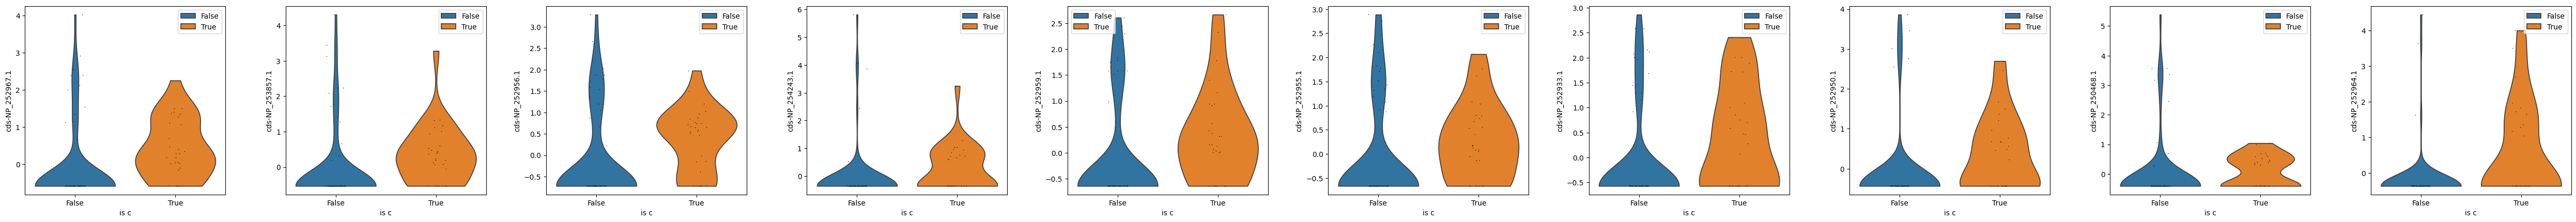

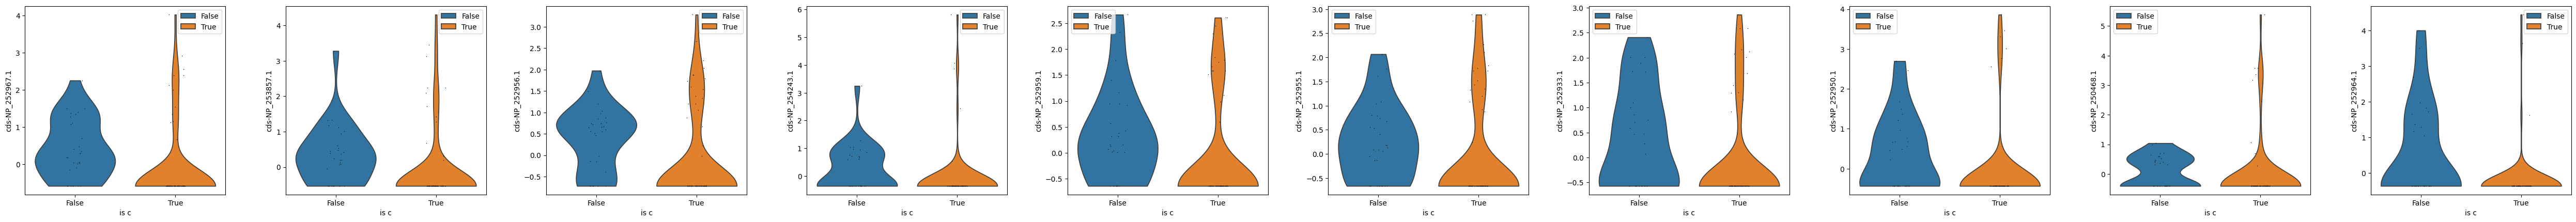

In [43]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [44]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-NP_064721.1,4,0.038835,0.038100,96.116505,4.0,1.609438,4,0.037327,False,1.857413,...,NP_064721.1,chromosome replication initiator DnaA,dnaA,0.038835,0.037327,0.001508,poi,0.038835,inf,0.000148
cds-NP_064722.1,5,0.048544,0.047402,95.145631,5.0,1.791759,5,0.046187,False,2.081567,...,NP_064722.1,DNA polymerase III subunit beta,dnaN,0.048544,0.046187,0.002356,poi,0.048540,inf,0.000103
cds-NP_064723.1,9,0.097087,0.092659,91.262136,10.0,2.397895,9,0.107079,False,1.723838,...,NP_064723.1,DNA replication and repair protein RecF,recF,0.097087,0.107079,-0.009992,nb,0.097090,0.818744,0.000000
cds-NP_064724.1,7,0.077670,0.074801,93.203883,8.0,2.197225,7,0.091055,False,0.936137,...,NP_064724.1,DNA gyrase subunit B,gyrB,0.077670,0.091055,-0.013385,nb,0.077669,0.376754,0.000000
cds-NP_064728.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490749,...,NP_064728.1,glycine--tRNA ligase subunit beta,glyS,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_254251.1,2,0.019417,0.019231,98.058252,2.0,1.098612,2,0.019040,False,1.325264,...,NP_254251.1,16S rRNA methyltransferase GidB,gidB,0.019417,0.019040,0.000377,poi,0.019420,inf,0.000611
cds-NP_254252.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490749,...,NP_254252.1,tRNA uridine 5-carboxymethylaminomethyl modifi...,gidA,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
cds-NP_254255.1,6,0.058252,0.056619,94.174757,6.0,1.945910,6,0.054859,False,2.264614,...,NP_254255.1,inner membrane protein translocase subunit YidC,NaN,0.058252,0.054859,0.003393,poi,0.058253,inf,0.000108
cds-NP_254256.1,4,0.048544,0.047402,96.116505,5.0,1.791759,4,0.065605,False,0.271007,...,NP_254256.1,ribonuclease P,rnpA,0.048544,0.065605,-0.017061,nb,0.048540,0.102454,0.000000


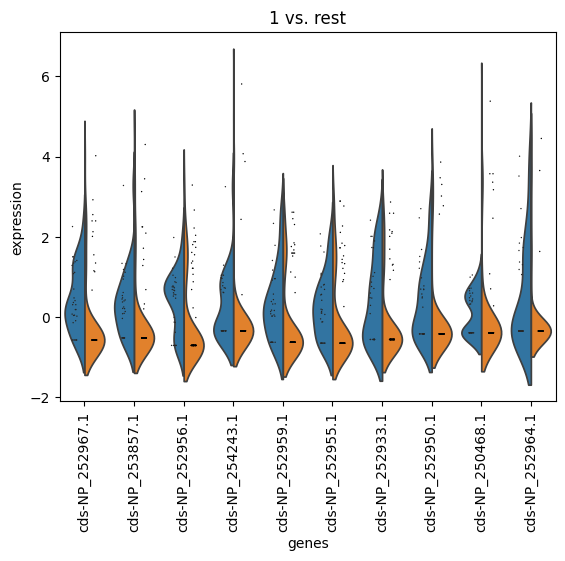

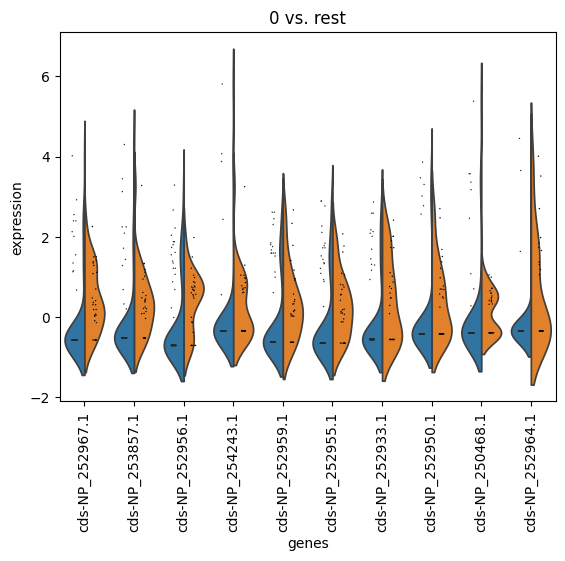

In [45]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [46]:
p_cutoff = 0.05
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].loc[data_gene_nonzero.uns["ClusterDE_results"][c]["q"] < p_cutoff,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 1
                locus_tag                                       name symbol
cds-NP_252967.1    PA4277                       elongation factor Tu   tufB
cds-NP_253857.1    PA5170              arginine/ornithine antiporter   arcD
cds-NP_252956.1    PA4266                        elongation factor G  fusA1
cds-NP_254243.1    PA5556                 ATP synthase subunit alpha   atpA
cds-NP_252959.1    PA4269  DNA-directed RNA polymerase subunit beta'   rpoC
...                   ...                                        ...    ...
cds-NP_252926.1    PA4236                                   catalase   katA
cds-NP_252929.1    PA4239                   30S ribosomal protein S4   rpsD
cds-NP_251257.1    PA2567                       hypothetical protein    NaN
cds-NP_253738.1    PA5051                      arginine--tRNA ligase   argS
cds-NP_064723.1    PA0003    DNA replication and repair protein RecF   recF

[61 rows x 3 columns]
Cluster 0
                locus_tag                    

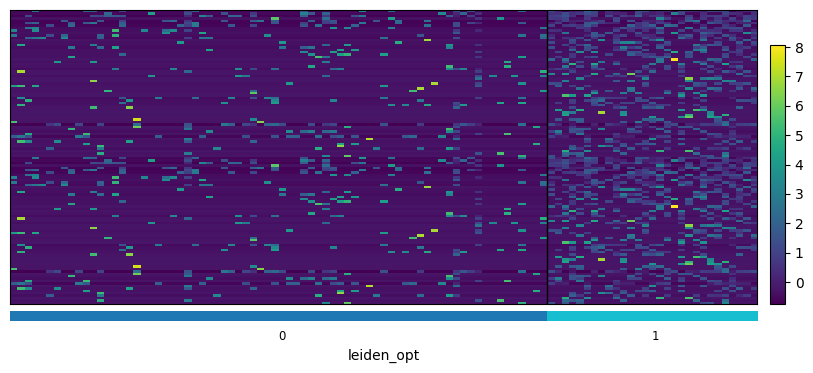

In [47]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)